# How to approch a problem
1. Loading of the dataset
2. Preparation of the dataset
3. Definition of the model
4. Train the model
5. Evaluation of the model
6. Presentation of results.
7. Save the model
8. Test the model



## 1. Load the data

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


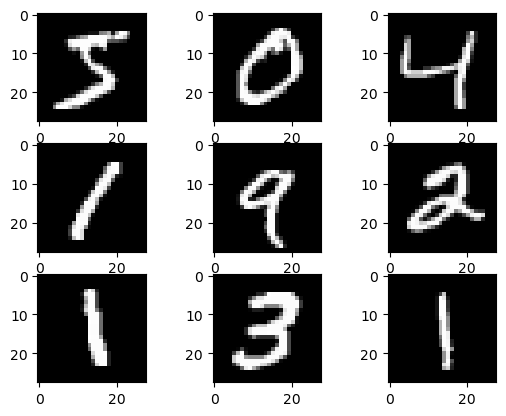

In [119]:
# Import some libraries
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset from api
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))
# plot first nine images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

## 2. Preparation of the dataset
Convert dataset labels vector to categorical data matrix
### Normalize, Center, and Standardize Image Pixels in Keras
1. Pixel Normalization: scale pixel values to the range 0-1
2. Pixel Centering: scale pixel values to have zero mean
3. Pixel Standardization: scale pixel values to have zero mean and unit variance

In [120]:
from tensorflow.keras.utils import to_categorical
# reshape dataset to have a single channel
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))
#Fråga.... kan ovan kod ersättas med model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
#transform labels to something that categorical_crossentropy can handel
train_labels = to_categorical(train_labels, dtype ="uint8")
test_labels = to_categorical(test_labels, dtype ="uint8")
# Testing set labels
print(test_labels)
print(test_labels.shape)

[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(10000, 10)


In [121]:
from keras.preprocessing.image import ImageDataGenerator
# Normalize
#Fråga varför göra såhär istället för image = image/255
datagen = ImageDataGenerator(rescale=1.0/255.0)
# Scale images
train_iterator = datagen.flow(train_images,train_labels,batch_size=32)
test_iterator = datagen.flow(test_images,test_labels,batch_size=32)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))
# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Batches train=1875, test=313
Batch shape=(32, 28, 28, 1), min=0.000, max=1.000


## 3. Definition of the model

In [122]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
#Create model
#def define_model():
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)


## 4. Train the model

In [125]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=5)
model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=5, validation_split=.2)
#    return model
#_, acc = model.evaluate(test_iterator, steps=len(test_iterator), verbose=0)
#print('Test Accuracy: %.3f' % (acc * 100))

Epoch 1/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0119 - accuracy: 0.9964
Epoch 2/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0100 - accuracy: 0.9969
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0081 - accuracy: 0.9976
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0050 - accuracy: 0.9989
Epoch 5/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0040 - accuracy: 0.9991


## 5. Evaluate the model

In [127]:
# evaluate a model using k-fold cross-validation
from sklearn.model_selection import KFold

#def evaluate_model(train_images, train_labels, n_folds=5):
dataX = train_images
dataY = train_labels 
n_folds=5
scores, histories = list(), list()
# prepare cross validation
kfold = KFold(n_folds, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in kfold.split(dataX):
	# select rows for train and test
	train_images = dataX[train_ix] 
	train_labels = dataY[train_ix]
	test_images = dataX[test_ix]
	test_labels = dataY[test_ix] 
	# fit model
	history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels), verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_images, test_labels, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# stores scores
	scores.append(acc)
	histories.append(history)

> 99.900
> 99.983
> 99.992
> 100.000
> 100.000


## 6. Present the model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               540900    
                                                                 
 batch_normalization_7 (Batc  (None, 100)             

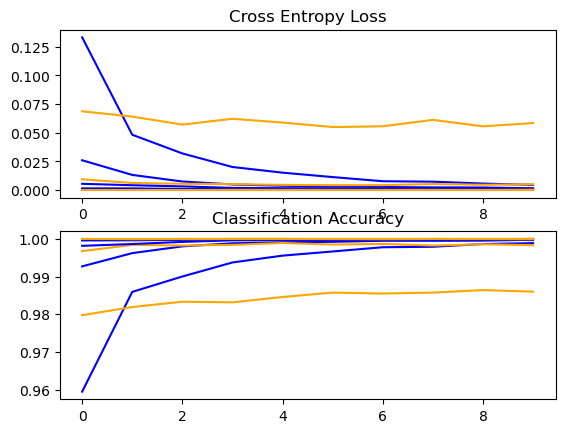

In [ ]:
#Show model summery
model.summary()
# plot diagnostic learning curves
#def summarize_diagnostics(histories):
for i in range(len(histories)):
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss')
	plt.plot(histories[i].history['loss'], color='blue', label='train')
	plt.plot(histories[i].history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy')
	plt.plot(histories[i].history['accuracy'], color='blue', label='train')
	plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
plt.show()

[0.9860000014305115, 0.9983333349227905, 0.999916672706604, 1.0, 1.0]
Accuracy: mean=99.685 std=0.546, n=5


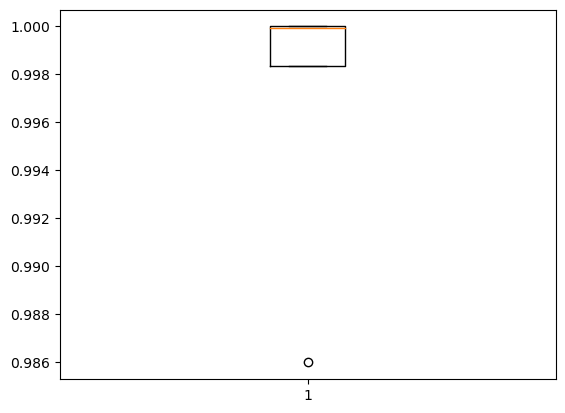

In [ ]:
# summarize model performance
from numpy import mean
from numpy import std
# print summary
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# box and whisker plots of results
plt.boxplot(scores)
plt.show()

## 7. Save the model

In [ ]:
model.save('final_model.h5')

## 8, Test the model with the test data from MINST dataset

9854
1/1 [==============================] - 0s 29ms/step
[[1.0287570e-14 5.9293181e-11 2.1458698e-17 2.6099872e-14 5.9553673e-10
  7.0355939e-13 1.2199713e-12 9.7822982e-12 1.1131576e-15 1.0000000e+00]]
The predicted number is:  9


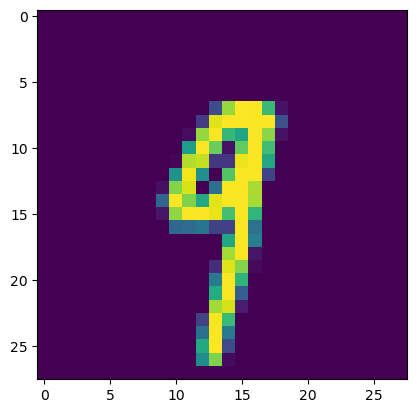

In [137]:
from numpy import argmax
import random as rand
randomimage = rand.randint(1,len(test_images))
print(randomimage)
plt.imshow(test_images[randomimage])
#from tf.keras.utils import img_to_array
img = test_images[randomimage]
# convert to array
#img = img_to_array(img)
# reshape into a single sample with 1 channel
img = img.reshape(1, 28, 28, 1)
predict_value = model.predict(img)
print(predict_value)
digit = argmax(predict_value)
print("The predicted number is: ",digit)

## 8. Test the model with my own image

1/1 [==============================] - 0s 23ms/step
The number is:   2


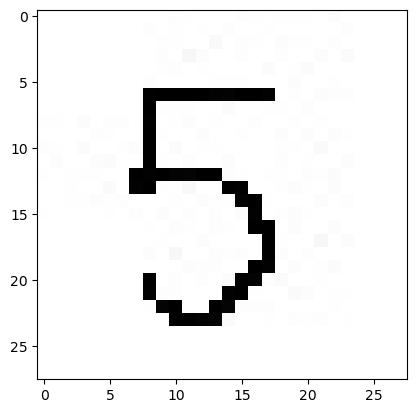

In [134]:
# make a prediction for a new image.
from numpy import argmax
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model

img = load_img('5.jpg',color_mode="grayscale",target_size=(28, 28))
#plot image
plt.imshow(img, cmap=plt.get_cmap('gray'))#, cmap=plt.get_cmap('gray'))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 1 channel
img = img.reshape(1, 28, 28, 1)

# prepare pixel data
img = img.astype('float32')
img = img / 255.0
#print (img)

# load model
#model = load_model('final_model.h5')
# predict the class
predict_value = model.predict(img)
digit = argmax(predict_value)
print("The number is:  ",digit)


## Anteckningar
### Epochs
 The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.
###
Difference between fit() and fit_generator()
https://blog.fnp.dev/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

## Referenser
code snipits from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/